<a href="https://colab.research.google.com/github/ras1364/DetectFakeReviewsUsing-Sentence_BERT/blob/main/FakeReviewsWithSentenceEmbeddingUsingSBERT_Ver1_0_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
from keras.layers import Embedding
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from keras.models import Model, Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
# from gensim.models import Word2Vec
# from gensim.models import Doc2Vec
# from gensim.models import doc2vec
from gensim.models import KeyedVectors
import itertools, nltk, snowballstemmer, re

import tensorflow as tf
from tensorflow import keras 

In [3]:
data = pd.read_csv("/content/sample_data/deceptive-opinion.csv")
data.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [4]:
data['polarity'] = np.where(data['polarity']=='positive',1,0)
data['deceptive'] = np.where(data['deceptive']=='truthful', 1,0)
data.head()

,deceptive,hotel,polarity,source,text
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...


In [5]:
df = data.sample(frac=1)
df.head()

,deceptive,hotel,polarity,source,text
523,0,knickerbocker,1,MTurk,"The entrance and room was spacious and modern,..."
210,1,hardrock,1,TripAdvisor,A bunch of us got together and we had a great ...
487,0,swissotel,1,MTurk,Elegant and modernized hotel with great staff....
503,0,knickerbocker,1,MTurk,I enjoyed a pleasant 2 night stay at the Mille...
184,1,hardrock,1,TripAdvisor,Got a great deal through Hotwire for $70 a nig...


In [6]:
df.describe()

,deceptive,polarity
count,1600.000000,1600.000000
mean,0.500000,0.500000
std,0.500156,0.500156
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.500000,0.500000
75%,1.000000,1.000000
max,1.000000,1.000000


In [7]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]
    
def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)
data['final_class']

0       [1, 1]
1       [1, 1]
2       [1, 1]
3       [1, 1]
4       [1, 1]
         ...  
1595    [0, 0]
1596    [0, 0]
1597    [0, 0]
1598    [0, 0]
1599    [0, 0]
Name: final_class, Length: 1600, dtype: object

In [ ]:
# data['given_class']

In [ ]:
# data.head()

In [8]:
# Number of sentece in each review 
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
splitedReviews = []
for sen in data.text:
  data["NumberOfSentece"] = len(sent_tokenize(sen))
  # splitedReviews.append( sent_tokenize(sen))
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE,13
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE,13
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE,13
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE,13
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE,13


In [9]:
sum =0
for a in data.NumberOfSentece:
  sum += a
print("Average number of reviews : ", sum/len(data), "  Sum = ",sum , "  Length = ", len(data) )
print("Max number of sentece in review : ", max(data["NumberOfSentece"]))

Average number of reviews :  13.0   Sum =  20800   Length =  1600
Max number of sentece in review :  13


In [10]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
data['given_class']= label_encoder.fit_transform(data['given_class']) 
data['given_class'].unique()

array([3, 1, 2, 0])

In [11]:
Y = data['given_class']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13


In [12]:
textData = pd.DataFrame(list(data["text"])) # each row is one document; the raw text of the document should be in the 'text_data' column
textData.head()

,0
0,We stayed for a one night getaway with family ...
1,Triple A rate with upgrade to view room was le...
2,This comes a little late as I'm finally catchi...
3,The Omni Chicago really delivers on all fronts...
4,I asked for a high floor away from the elevato...


In [13]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

data["stemmed_text_data"] = data["text"].map(preprocess)

In [ ]:
# data.head()

In [14]:
data["given_class"].value_counts()

3    400
1    400
2    400
0    400
Name: given_class, dtype: int64

In [15]:
data['length']=data['stemmed_text_data'].apply(len)
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece,stemmed_text_data,length
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13,We stayed night getaway family thursday. Tripl...,364
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13,Triple A rate upgrade view room $200 included ...,227
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13,This comes little late I'm finally catching re...,714
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13,"The Omni Chicago delivers fronts, spaciousness...",469
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13,I asked high floor away elevator I got. The ro...,231


In [ ]:
print("The most words in a sentence = ",data.length.max())

The most words in a sentence =  2773


In [16]:
splitedReviews = []
for sentence in data.stemmed_text_data:
  splitedReviews.append(sent_tokenize(sentence))

In [17]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=c50e838aa8a918eec9122b3caf6cd0d098e545620d3b5b47883f303b5fc48122
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [87]:
sentence_embeddings=[]
for row in splitedReviews:
  review_encoded=[]
  for sentence in row:
    review_encoded.append(sbert_model.encode(sentence))#, show_progress_bar=True))
  loop = 50 - len(review_encoded)

  for x in range(loop):
    review_encoded.append([0]*384) 
  sentence_embeddings.append(review_encoded)

np.shape(sentence_embeddings)

(1600, 50, 384)

In [88]:
np.shape(sentence_embeddings)

(1600, 50, 384)

In [41]:
# max = 0
# for review in sentence_embeddings:
#   b = np.shape(review)[0]
#   if(b>max):
#     max = b

# print("Number of sentence : ",max)

Number of sentence :  49


In [89]:
from sklearn.model_selection import train_test_split
X = sentence_embeddings
y = data["deceptive"]


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
# maxlength = []
# for i in range(0,len(data.stemmed_text_data)):
#     maxlength.append(len(data.stemmed_text_data[i]))
    
# print(max(maxlength) )

2300


In [90]:
# X_train_new 
print("X_train.shape =" ,np.shape(X_train),", y_train =", np.shape(y_train))
print("X_test.shape =" ,np.shape(X_test),", y_test =", np.shape(y_test))
print(np.shape(X_train))

X_train.shape = (1200, 50, 384) , y_train = (1200,)
X_test.shape = (400, 50, 384) , y_test = (400,)
(1200, 50, 384)


In [91]:
print(type(X_train))

<class 'list'>


In [93]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1200, input_shape=(50,384)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1200)              7608000   
                                                                 
 dense_4 (Dense)             (None, 64)                76864     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,684,929
Trainable params: 7,684,929
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
history = model.fit(x=np.array(X_train), y=np.array(y_train), epochs=10,
                    validation_data=(np.array(X_test),np.array(y_test)),
                    shuffle=True,
                    validation_steps=10)

Epoch 1/10
38/38 [==============================] - 95s 2s/step - loss: 0.6932 - accuracy: 0.4858 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
38/38 [==============================] - 88s 2s/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 3/10
38/38 [==============================] - 88s 2s/step - loss: 0.6929 - accuracy: 0.5117 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 4/10
38/38 [==============================] - 88s 2s/step - loss: 0.6778 - accuracy: 0.5483 - val_loss: 0.5947 - val_accuracy: 0.7600
Epoch 5/10
38/38 [==============================] - 87s 2s/step - loss: 0.5287 - accuracy: 0.7542 - val_loss: 0.4357 - val_accuracy: 0.8075
Epoch 6/10
38/38 [==============================] - 87s 2s/step - loss: 0.4121 - accuracy: 0.8117 - val_loss: 0.4091 - val_accuracy: 0.8375
Epoch 7/10
38/38 [==============================] - 87s 2s/step - loss: 0.3638 - accuracy: 0.8392 - val_loss: 0.4073 - val_accuracy: 0.8400
Epoch 8/10
38/38 [==

In [97]:
model.evaluate(np.array(X_test), np.array(y_test))

13/13 [==============================] - 9s 638ms/step - loss: 0.4163 - accuracy: 0.8275


[0.4163478910923004, 0.8274999856948853]

In [99]:
y_predicted = model.predict(np.array(X_test))
y_predicted = y_predicted.flatten()

13/13 [==============================] - 10s 708ms/step


In [100]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,

In [101]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[155,  45],
       [ 24, 176]])

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       200
           1       0.80      0.88      0.84       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



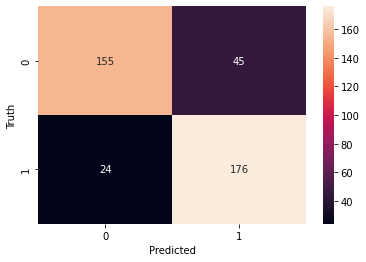

In [103]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_predicted))